In [1]:
import os
import cv2
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from scipy.spatial.distance import cosine
from PIL import Image

c:\Users\Jason Christian\anaconda3\envs\FaceNet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path= './training_data/Brian Alexander/aug_0_WhatsApp Image 2025-09-21 at 11.14.19_355b0534.jpg'

In [3]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize MTCNN (face detection)
mtcnn = MTCNN(keep_all=True, device=device)

# Load the pretrained FaceNet model (feature extractor mode)
model = InceptionResnetV1(pretrained='vggface2').to(device)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last few layers for fine-tuning
for param in model.block8.parameters():  # Last layers in FaceNet
    param.requires_grad = True
for param in model.last_linear.parameters():  # Final FC layer
    param.requires_grad = True

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = torch.nn.MSELoss()  # Using MSE loss for embeddings fine-tuning

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [4]:
import cv2
# Make sure you have the MTCNN instance defined, e.g.:
# from facenet_pytorch import MTCNN
# mtcnn = MTCNN(keep_all=True)

def detect_and_draw_faces(image_path):
    """
    Detect faces in an image and draw bounding boxes.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}. Please check if the file exists and is a valid image.")
        return

    # Convert to RGB for MTCNN detection
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform detection
    # Ensure 'mtcnn' is defined globally or passed as an argument
    detection_results = mtcnn.detect(img_rgb, landmarks=True)
    
    if detection_results is not None:
        boxes, probs, landmarks = detection_results
        
        if boxes is not None:
            for box in boxes:
                # Draw rectangle
                cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
        
        # --- VS CODE ADJUSTMENT STARTS HERE ---
        cv2.imshow("Detected Faces", img)
        
        # specific to local execution: waits indefinitely for a key press
        cv2.waitKey(0) 
        
        # closes the window after the key is pressed
        cv2.destroyAllWindows() 
        # --- VS CODE ADJUSTMENT ENDS HERE ---
        
    else:
        print("No faces detected.")

# Example Usage:
# detect_and_draw_faces('my_face.jpg')

In [5]:
def get_face_embeddings(image_path):
    """
    Extracts face embeddings from an image.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return []
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faces = mtcnn(img_rgb)
    embeddings = []
    if faces is not None:
        for face in faces:
            face = face.unsqueeze(0)
            # Move the input tensor to the same device as the model
            face = face.to(device)
            # Set the model to evaluation mode to avoid using batch statistics during inference
            model.eval()
            embedding = model(face)
            embeddings.append(embedding)
    return embeddings

In [6]:
dataset = './training_data/'
print(os.listdir(dataset))

['Alex', 'Brian Alexander', 'Jason', 'Melvern', 'Sally']


In [ ]:
person_embeddings = {}

# Iterate through each person's directory in the dataset
for person_name in os.listdir(dataset):
    person_dir = os.path.join(dataset, person_name)
    if os.path.isdir(person_dir):
        print(f"Processing images for: {person_name}")
        embeddings_for_person = []
        for image_file in os.listdir(person_dir):
            if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_path = os.path.join(person_dir, image_file)
                # Get embeddings for all faces in the current image
                current_image_embeddings = get_face_embeddings(image_path)
                if current_image_embeddings:
                    embeddings_for_person.extend(current_image_embeddings)
                else:
                    print(f"No faces detected in {image_path}, skipping.")
        if embeddings_for_person:
            person_embeddings[person_name] = embeddings_for_person
        else:
            print(f"No embeddings found for {person_name}. This person might be skipped if no faces were detected in any of their images.")

print("\nFace embedding extraction complete.")
print(f"Extracted embeddings for {len(person_embeddings)} individuals.")

Processing images for: Alex
Processing images for: Brian Alexander
Processing images for: Jason


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Prepare data for SVM
X = []  # Embeddings
y = []  # Labels

for person_name, embeddings_list in person_embeddings.items():
    for embedding_tensor in embeddings_list:
        # Detach the tensor from the GPU (if on GPU) and convert to numpy
        embedding_np = embedding_tensor.detach().cpu().numpy().flatten()
        X.append(embedding_np)
        y.append(person_name)

X = np.array(X)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Total samples for SVM: {len(X)}")
print(f"Total unique individuals: {len(label_encoder.classes_)}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# Train SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Evaluate the model
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nSVM Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Optionally, you can print the trained SVM model details
# print("\nSVM Model:", svm_model)

Total samples for SVM: 67
Total unique individuals: 5
Training samples: 53
Testing samples: 14

SVM Model Accuracy: 1.0000

Classification Report:
                 precision    recall  f1-score   support

           Alex       1.00      1.00      1.00         1
Brian Alexander       1.00      1.00      1.00         2
          Jason       1.00      1.00      1.00         2
        Melvern       1.00      1.00      1.00         8
          Sally       1.00      1.00      1.00         1

       accuracy                           1.00        14
      macro avg       1.00      1.00      1.00        14
   weighted avg       1.00      1.00      1.00        14



In [ ]:
import cv2
import os
from PIL import Image  # Required for Image.fromarray

def recognize_person(image_path, model, label_encoder, mtcnn_detector, embedding_model):
    # 1. Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}.")
        return

    # Convert to RGB for MTCNN operations (MTCNN expects RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Detect faces
    try:
        detection_results = mtcnn_detector.detect(img_rgb, landmarks=True)
    except Exception as e:
        print(f"Error during face detection with landmarks: {e}")
        print("Attempting to detect without landmarks as fallback.")
        detection_results = mtcnn_detector.detect(img_rgb, landmarks=False)

    if detection_results is not None and len(detection_results) >= 2:
        boxes = detection_results[0]
        
        if boxes is not None and len(boxes) > 0:
            # 3. Extract aligned faces
            # Note: Ensure 'device' is defined globally in your script (e.g., device = 'cuda' or 'cpu')
            faces_aligned = mtcnn_detector.extract(Image.fromarray(img_rgb), boxes, save_path=None)

            if faces_aligned is not None and len(faces_aligned) > 0:
                for i, face_tensor in enumerate(faces_aligned):
                    # Prepare tensor for embedding model
                    face_tensor = face_tensor.unsqueeze(0).to(device) 
                    embedding = embedding_model(face_tensor).detach().cpu().numpy().flatten()

                    # Predict
                    predicted_label_encoded = model.predict([embedding])
                    predicted_person = label_encoder.inverse_transform(predicted_label_encoded)
                    
                    # Probability / Confidence
                    probabilities = model.predict_proba([embedding])[0]
                    confidence = probabilities[predicted_label_encoded[0]]
                    
                    print(f"Detected face {i+1} in {os.path.basename(image_path)} is: {predicted_person[0]}")
                    print(f"Confidence: {confidence:.2f}")

                    # Draw bounding box and label
                    if i < len(boxes):
                        box = boxes[i]
                        # Drawing on img_rgb
                        cv2.rectangle(img_rgb, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
                        cv2.putText(img_rgb, f"{predicted_person[0]} ({confidence:.2f})", 
                                    (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                # --- VS CODE ADJUSTMENT START ---
                # Convert RGB back to BGR for OpenCV display
                final_display_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
                
                # Create the window
                cv2.imshow("Recognition Result", final_display_img)
                
                # Wait indefinitely until a key is pressed
                cv2.waitKey(0)
                
                # Close the window
                cv2.destroyAllWindows()
                # --- VS CODE ADJUSTMENT END ---

            else:
                print(f"No aligned faces could be extracted from {os.path.basename(image_path)}.")
        else:
            print(f"No bounding boxes were detected for faces in {os.path.basename(image_path)}.")
    else:
        print(f"No faces detected or unexpected output in {os.path.basename(image_path)}.")

# Usage

input_image_path = './training_data/Alex/Alex1.jpg'
# Ensure these variables (input_image_path, svm_model, etc.) are defined above this function
recognize_person(input_image_path, svm_model, label_encoder, mtcnn, model)

Detected face 1 in Alex1.jpg is: Alex
Confidence: 0.35


In [ ]:
from collections import defaultdict
import math

class FaceTracker:
    """
    Tracks faces across frames to maintain stable bounding boxes and labels.
    """
    def __init__(self, max_distance=50, max_age=30):
        self.tracks = {}  # {track_id: {'box': box, 'label': label, 'confidence': conf, 'age': age}}
        self.next_id = 0
        self.max_distance = max_distance  # Max distance to consider same face
        self.max_age = max_age  # Frames to keep track alive without detection
    
    def distance(self, box1, box2):
        """Calculate distance between two bounding boxes (center to center)."""
        x1_center = (box1[0] + box1[2]) / 2
        y1_center = (box1[1] + box1[3]) / 2
        x2_center = (box2[0] + box2[2]) / 2
        y2_center = (box2[1] + box2[3]) / 2
        return math.sqrt((x1_center - x2_center)**2 + (y1_center - y2_center)**2)
    
    def update(self, detections):
        """
        Update tracks with new detections.
        detections: list of {'box': box, 'label': label, 'confidence': conf}
        """
        # Increment age of all tracks
        for track_id in list(self.tracks.keys()):
            self.tracks[track_id]['age'] += 1
            if self.tracks[track_id]['age'] > self.max_age:
                del self.tracks[track_id]
        
        # Match detections to existing tracks
        used_detections = set()
        
        for track_id, track in self.tracks.items():
            best_distance = float('inf')
            best_detection_idx = -1
            
            for det_idx, detection in enumerate(detections):
                if det_idx in used_detections:
                    continue
                
                dist = self.distance(track['box'], detection['box'])
                if dist < best_distance and dist < self.max_distance:
                    best_distance = dist
                    best_detection_idx = det_idx
            
            if best_detection_idx >= 0:
                # Update track with new detection
                detection = detections[best_detection_idx]
                self.tracks[track_id]['box'] = detection['box']
                self.tracks[track_id]['label'] = detection['label']
                self.tracks[track_id]['confidence'] = detection['confidence']
                self.tracks[track_id]['age'] = 0  # Reset age
                used_detections.add(best_detection_idx)
        
        # Create new tracks for unmatched detections
        for det_idx, detection in enumerate(detections):
            if det_idx not in used_detections:
                self.tracks[self.next_id] = {
                    'box': detection['box'],
                    'label': detection['label'],
                    'confidence': detection['confidence'],
                    'age': 0
                }
                self.next_id += 1
        
        return self.tracks


def live_face_recognition(model, label_encoder, mtcnn_detector, embedding_model, confidence_threshold=0.5):
    """
    Performs live face recognition using webcam with object tracking.
    Press 'q' to quit.
    """
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return
    
    print("Starting live face recognition with tracking. Press 'q' to quit.")
    
    # Set camera resolution for better performance
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    frame_count = 0
    detection_interval = 3  # Detect faces every 3 frames
    tracker = FaceTracker(max_distance=60, max_age=20)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to read frame from camera.")
            break
        
        frame_count += 1
        detections = []
        
        # Perform face detection every N frames
        if frame_count % detection_interval == 0:
            try:
                # Convert BGR to RGB for processing
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                # Detect faces
                detection_results = mtcnn_detector.detect(frame_rgb, landmarks=False)
                
                if detection_results is not None and len(detection_results) >= 1:
                    boxes = detection_results[0]
                    
                    if boxes is not None and len(boxes) > 0:
                        # Extract aligned faces
                        try:
                            faces_aligned = mtcnn_detector.extract(Image.fromarray(frame_rgb), boxes, save_path=None)
                            
                            if faces_aligned is not None and len(faces_aligned) > 0:
                                for i, face_tensor in enumerate(faces_aligned):
                                    if i < len(boxes):
                                        # Get embedding
                                        face_tensor = face_tensor.unsqueeze(0).to(device)
                                        embedding_model.eval()
                                        embedding = embedding_model(face_tensor).detach().cpu().numpy().flatten()
                                        
                                        # Predict
                                        predicted_label_encoded = model.predict([embedding])
                                        predicted_person = label_encoder.inverse_transform(predicted_label_encoded)
                                        
                                        # Get confidence
                                        probabilities = model.predict_proba([embedding])[0]
                                        confidence = probabilities[predicted_label_encoded[0]]
                                        
                                        # Prepare detection
                                        box = boxes[i]
                                        label_text = f"{predicted_person[0]} ({confidence:.2f})"
                                        if confidence < confidence_threshold:
                                            label_text = f"Unknown ({confidence:.2f})"
                                        
                                        detections.append({
                                            'box': box,
                                            'label': label_text,
                                            'confidence': confidence
                                        })
                        except Exception as e:
                            print(f"Error during face extraction: {e}")
            
            except Exception as e:
                print(f"Error during frame processing: {e}")
        
        # Update tracker with new detections
        tracked_faces = tracker.update(detections)
        
        # Draw tracked faces on frame
        for track_id, track in tracked_faces.items():
            box = track['box']
            label = track['label']
            
            # Determine color based on age (newer tracks are brighter)
            brightness = max(50, 255 - (track['age'] * 10))
            color = (0, int(brightness), 0) if 'Unknown' not in label else (0, 0, int(brightness))
            
            # Draw bounding box
            cv2.rectangle(frame, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
            
            # Draw label with background for better visibility
            text = label
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            thickness = 2
            
            # Get text size for background
            text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
            text_x = int(box[0])
            text_y = int(box[1]) - 10
            
            # Draw background rectangle for text
            cv2.rectangle(frame, (text_x, text_y - text_size[1] - 5), 
                         (text_x + text_size[0] + 5, text_y + 5), color, -1)
            
            # Draw text
            cv2.putText(frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)
        
        # Display the frame
        cv2.imshow("Live Face Recognition with Tracking", frame)
        
        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()
    print("Live face recognition stopped.")

# Run live face recognition with tracking
live_face_recognition(svm_model, label_encoder, mtcnn, model, confidence_threshold=0.5)

Starting live face recognition with tracking. Press 'q' to quit.
Live face recognition stopped.


In [11]:
# Check embedding dimension
print("Embedding Dimension Check:")
print("=" * 50)

# Get a sample embedding from the model
sample_face = torch.randn(1, 3, 160, 160).to(device)  # Random face tensor (batch_size=1, channels=3, height=160, width=160)
with torch.no_grad():
    sample_embedding = model(sample_face)

embedding_dim = sample_embedding.shape[-1]
print(f"Embedding dimension: {embedding_dim}")
print(f"Embedding shape: {sample_embedding.shape}")

# Check the SVM model's expected input dimension
svm_input_dim = svm_model.support_vectors_.shape[1]
print(f"SVM model expects input dimension: {svm_input_dim}")

# Check if dimensions match
if embedding_dim == svm_input_dim:
    print(f"✓ Embedding and SVM dimensions match! ({embedding_dim}D)")
else:
    print(f"✗ WARNING: Dimension mismatch! Embedding: {embedding_dim}D, SVM expects: {svm_input_dim}D")

print("\n" + "=" * 50)
print("Saving SVM Model...")
print("=" * 50)

# Save the SVM model and label encoder
import pickle

model_data = {
    'svm_model': svm_model,
    'label_encoder': label_encoder,
    'embedding_dim': embedding_dim
}

model_path = 'face_recognition_svm_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✓ Model saved to: {model_path}")
print(f"  - SVM classifier")
print(f"  - Label encoder")
print(f"  - Embedding dimension: {embedding_dim}")
print("\nYou can now load this model for inference without retraining.")

Embedding Dimension Check:
Embedding dimension: 512
Embedding shape: torch.Size([1, 512])
SVM model expects input dimension: 512
✓ Embedding and SVM dimensions match! (512D)

Saving SVM Model...
✓ Model saved to: face_recognition_svm_model.pkl
  - SVM classifier
  - Label encoder
  - Embedding dimension: 512

You can now load this model for inference without retraining.


In [ ]:
import pickle

model_path = 'face_recognition_svm_model.pkl'

try:
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    
    # Extract loaded components
    loaded_svm_model = model_data['svm_model']
    loaded_label_encoder = model_data['label_encoder']
    loaded_embedding_dim = model_data['embedding_dim']
    
    print("✓ Model successfully loaded from:", model_path)
    print(f"  - SVM classifier loaded")
    print(f"  - Label encoder loaded")
    print(f"  - Embedding dimension: {loaded_embedding_dim}")
    print(f"  - Number of classes: {len(loaded_label_encoder.classes_)}")
    print(f"  - Classes: {list(loaded_label_encoder.classes_)}")
    
except FileNotFoundError:
    print(f"✗ Error: Model file not found at {model_path}")
    print("  Please ensure you have trained and saved the model first.")
except Exception as e:
    print(f"✗ Error loading model: {e}")


✓ Model successfully loaded from: face_recognition_svm_model.pkl
  - SVM classifier loaded
  - Label encoder loaded
  - Embedding dimension: 512
  - Number of classes: 5
  - Classes: ['Alex', 'Brian Alexander', 'Jason', 'Melvern', 'Sally']


Using loaded model for recognition...

Recognition Results for: WhatsApp Image 2025-12-10 at 4.30.37 PM.jpeg

Face 1:
  Predicted: Brian Alexander
  Confidence: 0.7157

Face 1:
  Predicted: Brian Alexander
  Confidence: 0.7157


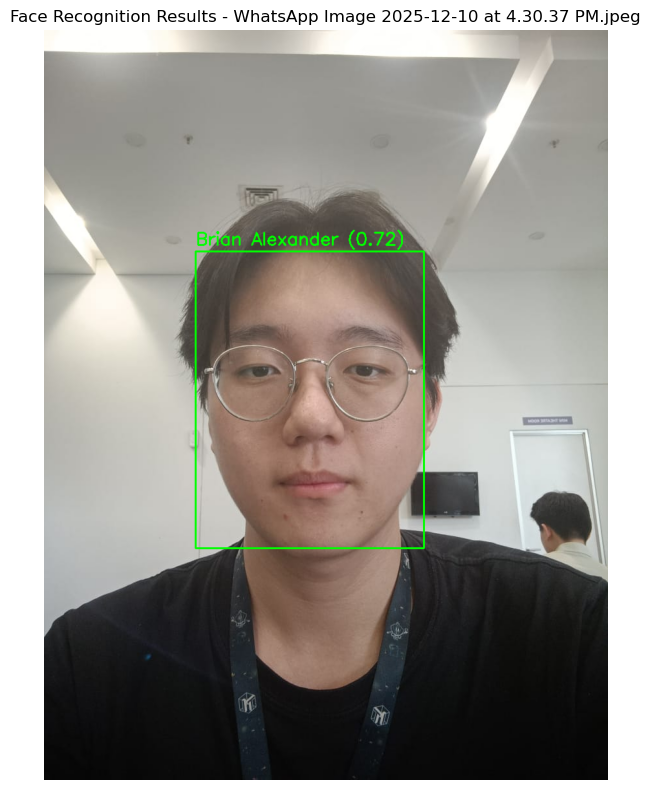

In [ ]:
def recognize_person_with_loaded_model(image_path, svm_model, label_encoder, mtcnn_detector, embedding_model, device):
    """
    Perform face recognition using the loaded SVM model and display results in the notebook.
    """
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from {image_path}.")
        return
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect faces
    try:
        detection_results = mtcnn_detector.detect(img_rgb, landmarks=False)
    except Exception as e:
        print(f"Error during face detection: {e}")
        return
    
    if detection_results is not None and len(detection_results) >= 1:
        boxes = detection_results[0]
        
        if boxes is not None and len(boxes) > 0:
            # Extract aligned faces
            try:
                faces_aligned = mtcnn_detector.extract(Image.fromarray(img_rgb), boxes, save_path=None)
                
                if faces_aligned is not None and len(faces_aligned) > 0:
                    print(f"\n{'='*60}")
                    print(f"Recognition Results for: {os.path.basename(image_path)}")
                    print(f"{'='*60}")
                    
                    for i, face_tensor in enumerate(faces_aligned):
                        if i < len(boxes):
                            # Get embedding using the pretrained model
                            face_tensor = face_tensor.unsqueeze(0).to(device)
                            embedding_model.eval()
                            with torch.no_grad():
                                embedding = embedding_model(face_tensor).detach().cpu().numpy().flatten()
                            
                            # Predict using loaded SVM model
                            predicted_label_encoded = svm_model.predict([embedding])
                            predicted_person = label_encoder.inverse_transform(predicted_label_encoded)
                            
                            # Get confidence
                            probabilities = svm_model.predict_proba([embedding])[0]
                            confidence = probabilities[predicted_label_encoded[0]]
                            
                            print(f"\nFace {i+1}:")
                            print(f"  Predicted: {predicted_person[0]}")
                            print(f"  Confidence: {confidence:.4f}")
                            
                            # Draw on image
                            box = boxes[i]
                            cv2.rectangle(img_rgb, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
                            label_text = f"{predicted_person[0]} ({confidence:.2f})"
                            cv2.putText(img_rgb, label_text, (int(box[0]), int(box[1])-10), 
                                       cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
                    
                    # Display results in notebook using matplotlib
                    from matplotlib import pyplot as plt
                    plt.figure(figsize=(12, 8))
                    plt.imshow(img_rgb)
                    plt.axis('off')
                    plt.title(f"Face Recognition Results - {os.path.basename(image_path)}")
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"{'='*60}\n")
                
                else:
                    print("No aligned faces could be extracted.")
            
            except Exception as e:
                print(f"Error during face extraction: {e}")
        else:
            print("No bounding boxes detected.")
    else:
        print("No faces detected in the image.")

test_image_path = './training_data/Brian Alexander\WhatsApp Image 2025-12-10 at 4.30.37 PM.jpeg'

if 'loaded_svm_model' in locals():
    print("Using loaded model for recognition...")
    recognize_person_with_loaded_model(
        test_image_path, 
        loaded_svm_model, 
        loaded_label_encoder, 
        mtcnn, 
        model, 
        device
    )
else:
    print("Error: Loaded model not found. Please run the model loading cell first.")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions on test set
y_test_pred = svm_model.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - SVM Face Recognition', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nConfusion Matrix Shape: {cm.shape}")
print(f"Total Predictions: {cm.sum()}")
print(f"Accuracy: {(cm.trace() / cm.sum()):.4f}")

In [ ]:
import cv2
import matplotlib.pyplot as plt

def predict_and_display_face(img_path, svm_model, label_encoder, mtcnn_detector, embedding_model, device):
    """
    Predict and display faces using FaceNet embeddings and SVM classifier
    
    Args:
        img_path: Path to the image file
        svm_model: Trained SVM classifier
        label_encoder: Label encoder for class names
        mtcnn_detector: MTCNN face detector
        embedding_model: FaceNet embedding model
        device: Device to run inference on (cuda or cpu)
    """
    # Read image
    image = cv2.imread(img_path)

    if image is None:
        print(f"Error: Could not load image from {img_path}")
        return

    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    try:
        # Detect faces using MTCNN
        boxes = mtcnn_detector.detect(image_rgb)[0]
    except Exception as e:
        print(f"Error during face detection for {img_path}: {e}")
        plt.imshow(image_rgb)
        plt.title(f"Error during face detection for {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    if boxes is None or len(boxes) == 0:
        print(f"No faces detected in {img_path}")
        plt.imshow(image_rgb)
        plt.title(f"No faces detected in {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
        return

    # Extract aligned faces
    try:
        faces_aligned = mtcnn_detector.extract(Image.fromarray(image_rgb), boxes, save_path=None)
    except Exception as e:
        print(f"Error extracting faces: {e}")
        return

    if faces_aligned is None or len(faces_aligned) == 0:
        print(f"Could not extract aligned faces from {img_path}")
        return

    # Make a copy of the image to draw on
    annotated_image = image_rgb.copy()

    # Process each detected face
    for i, face_tensor in enumerate(faces_aligned):
        if i >= len(boxes):
            break
            
        try:
            # Get bounding box coordinates
            bbox = boxes[i]
            x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
            
            # Get embedding from FaceNet
            face_tensor = face_tensor.unsqueeze(0).to(device)
            embedding_model.eval()
            with torch.no_grad():
                embedding = embedding_model(face_tensor).cpu().numpy().flatten()

            # Predict using SVM classifier
            predicted_class_idx = svm_model.predict([embedding])[0]
            predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
            confidence_score = svm_model.predict_proba([embedding]).max()

            # Draw rectangle around face
            color = (0, 255, 0)  # Green color in RGB
            thickness = 2
            cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, thickness)

            # Prepare text
            text = f"{predicted_class}: {confidence_score:.2f}"
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            font_thickness = 2
            text_color = (255, 255, 0)  # Yellow color in RGB

            # Get text size to place it correctly above the bounding box
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
            text_origin_x = x1
            text_origin_y = y1 - 10 if y1 - 10 > text_height else y1 + (y2 - y1) + text_height + 10

            # Put text on image
            cv2.putText(annotated_image, text, (text_origin_x, text_origin_y), 
                       font, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
            print(f"Face {i+1} detected at ({x1}, {y1}, {x2}, {y2}) -> Predicted: {predicted_class} (Confidence: {confidence_score:.4f})")

        except Exception as e:
            print(f"Error processing face {i}: {e}")
            continue

    # Display the annotated image
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image)
    plt.title(f"Prediction for {os.path.basename(img_path)}")
    plt.axis('off')
    plt.show()

# Example usage:
# predict_and_display_face('./training_data/Alex/Alex1.jpg', svm_model, label_encoder, mtcnn, model, device)